In [2]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr

from sklearn.linear_model import LinearRegression, LogisticRegression
from tqdm import tqdm

## Get Stock List

In [3]:
path = '../data'
list_name = 'stock_list.csv'
sample_name = 'sample_submission.csv'

stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


## Get Data & Modeling

In [4]:
start_date = '20210104'
# start_date = '20200106'
end_date = '20211105'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
NUM of WEEKS to "end_date" : 44
HOW MANY "Business_days" : (220, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


## Baseline 모델의 구성 소개 ( Sample )

- X : (월 ~ 금) * 43주간
- y : (다음주 월 ~ 금) * 43주간
    - y_0 : 다음주 월요일
    - y_1 : 다음주 화요일
    - y_2 : 다음주 수요일
    - y_3 : 다음주 목요일
    - y_4 : 다음주 금요일


- 이번주 월~금요일의 패턴을 학습해 다음주 월요일 ~ 금요일을 각각 예측하는 모델을 생성
    
- 이 과정을 모든 종목(370개)에 적용

In [5]:
stock_list.loc[0]

종목명       삼성전자
종목코드    005930
상장시장     KOSPI
Name: 0, dtype: object

In [6]:
'''
지금 오늘것을 입력해서 내일 종가를 맞추는 모형으로 만듦

- 문제는 지난 1주일(5일) 데이터로 다음 1주일(5일간) 종가를 맞추기
- 현재 하루 짜리 입력을 쓰는 것에서 5일짜리 입력을 쓰도록 수정필요

'''

sample_code = stock_list.loc[0,'종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date).reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))

feature_columns = 'Open	High	Low	Close	Volume	Change	weekday'.split()
for c in feature_columns:
    sample[c] = sample[c].ffill()
    sample[c] = sample[c].bfill()

    # weekday 는 log_regurn을 구하지 않음
    if c == 'weekday': continue
    sample['log_return_{}'.format(c)] = np.log(sample[c]).diff()

sample.head()

/home/jongoon/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jongoon/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jongoon/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,Date,Open,High,Low,Close,Volume,Change,weekday,weeknum,log_return_Open,log_return_High,log_return_Low,log_return_Close,log_return_Volume,log_return_Change
0,2021-01-04,81000.0,84400.0,80200.0,83000.0,38655276.0,0.024691,0,01,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-05,81600.0,83900.0,81600.0,83900.0,35335669.0,0.010843,1,01,0.007380,-0.005942,0.017306,0.010785,-0.089790,-0.822899
2,2021-01-06,83300.0,84500.0,82100.0,82200.0,42089013.0,-0.020262,2,01,0.020619,0.007126,0.006109,-0.020470,0.174894,NaN
3,2021-01-07,82800.0,84200.0,82700.0,82900.0,32644642.0,0.008516,3,01,-0.006020,-0.003557,0.007282,0.008480,-0.254106,NaN
4,2021-01-08,83300.0,90000.0,83000.0,88800.0,59013307.0,0.071170,4,01,0.006020,0.066615,0.003621,0.068752,0.592082,2.123148


## weekday


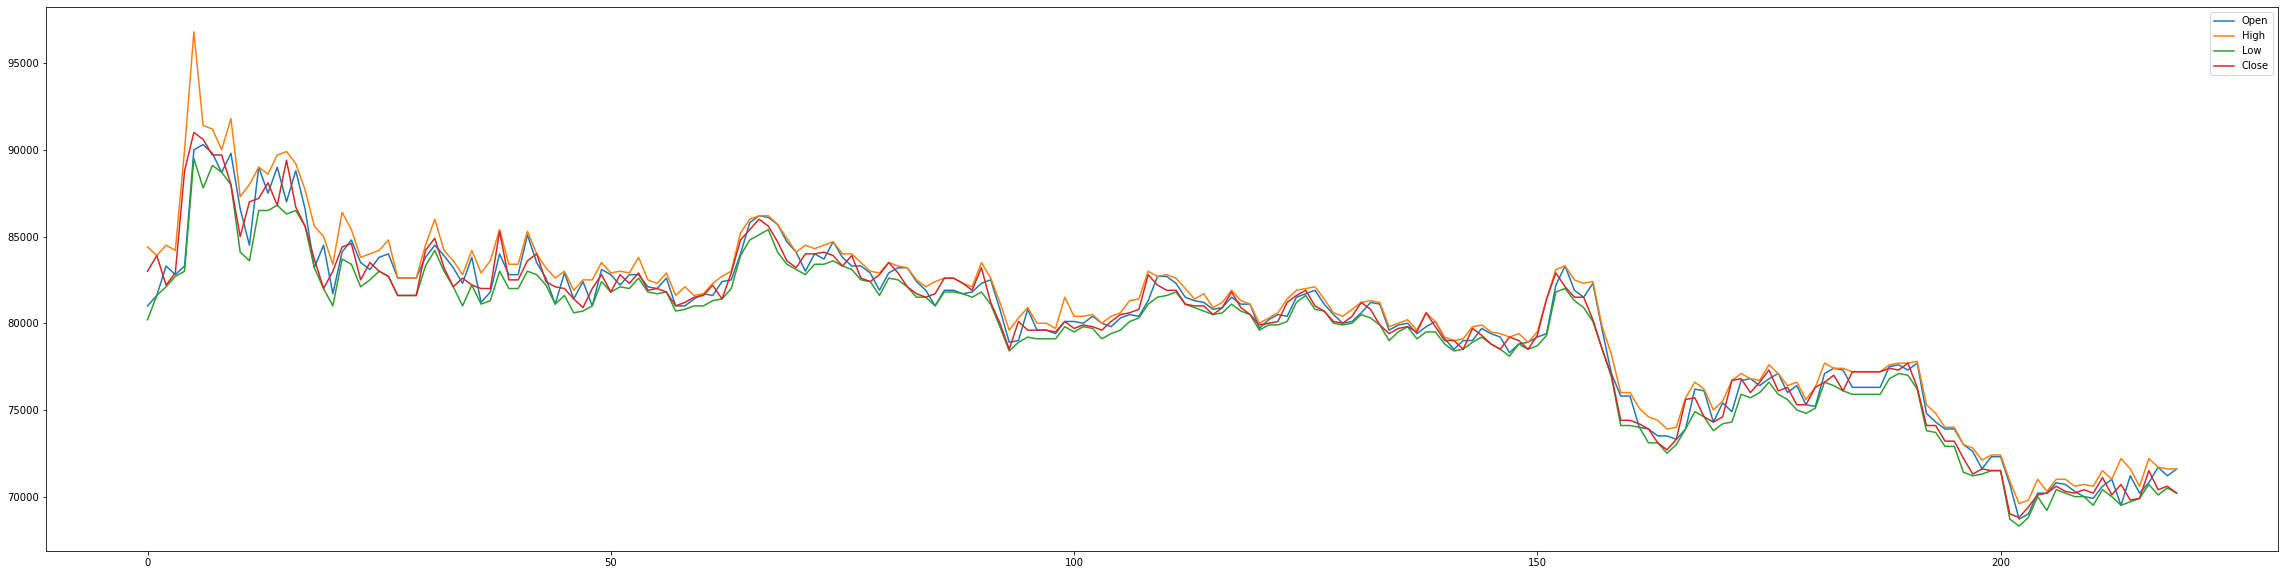

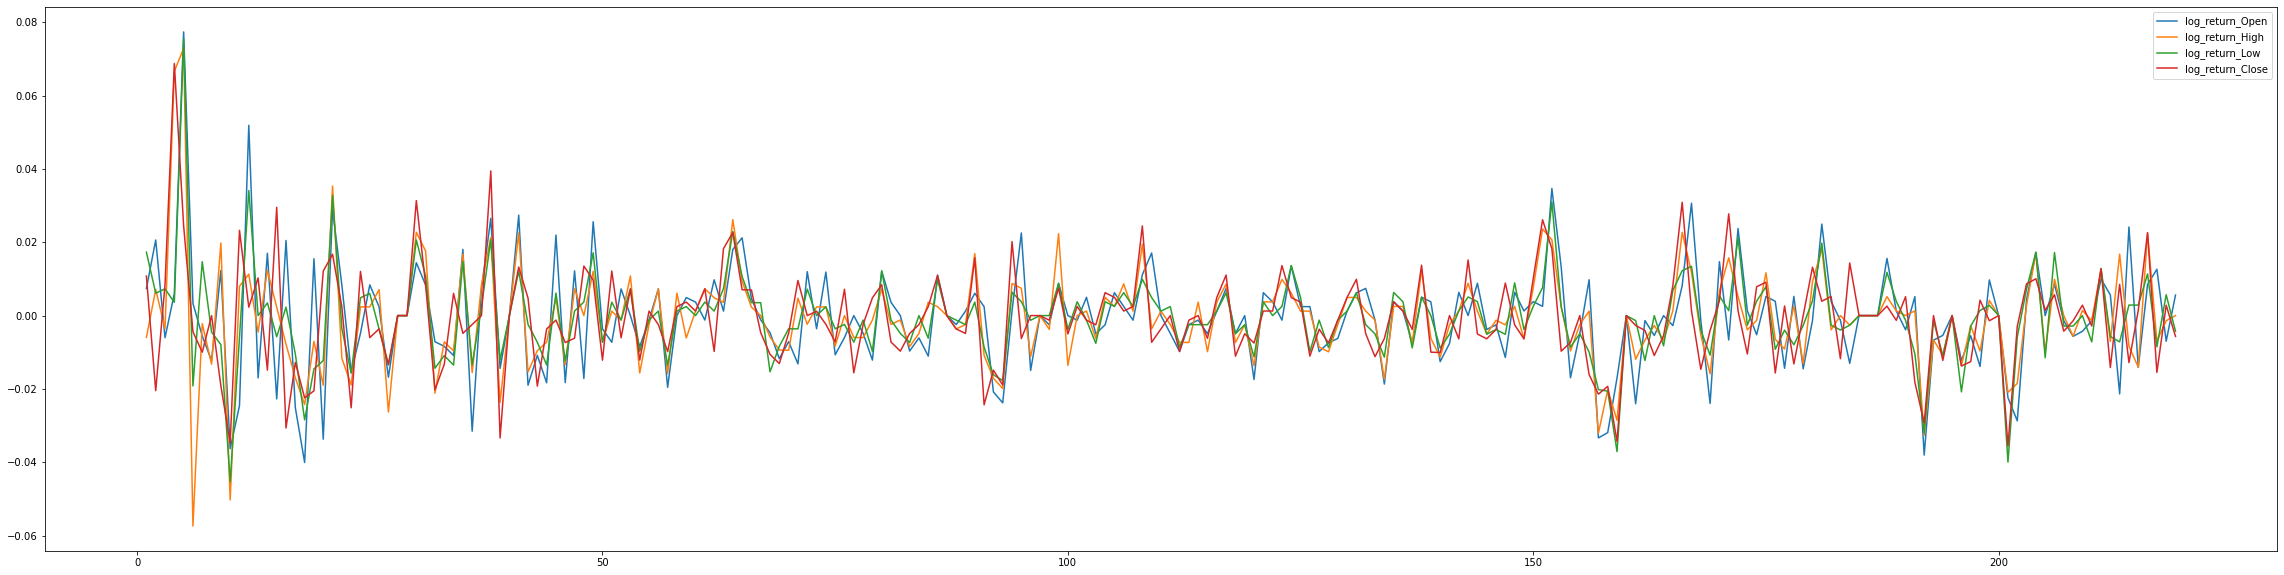

In [7]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (40, 10)
# for c in feature_columns:
#     # weekday 는 log_regurn을 구하지 않음
#     if c == 'weekday': continue
print('##', c)
sample['Open	High	Low	Close'.split()].plot()
plt.show()

sample[['log_return_{}'.format(c) for c in 'Open	High	Low	Close'.split()]].plot()
plt.show()


In [8]:
# 모형 1: 5일치 데이터(Open	High	Low	Close	Volume	Change	weekday)로 다음날 값을 예측
# 모형 2: 5일치 데이터(Open	High	Low	Close	Volume	Change	weekday)로 2일 뒤 값을 예측
# 모형 3: 5일치 데이터(Open	High	Low	Close	Volume	Change	weekday)로 3일 뒤 값을 예측
# 모형 4: 5일치 데이터(Open	High	Low	Close	Volume	Change	weekday)로 4일 뒤 값을 예측
# 모형 5: 5일치 데이터(Open	High	Low	Close	Volume	Change	weekday)로 5일 뒤 값을 예측

window_size = 5
X = np.array(
    [sample[feature_columns].iloc[i:i+window_size].to_numpy().reshape(-1) for i in range(len(sample) - 14)]
)
print(X.shape)
pd.DataFrame(X[-1].reshape(5, 7))

(206, 35)


,0,1,2,3,4,5,6
0,70200.0,70300.0,69200.0,70200.0,13486391.0,0.001427,0.0
1,70800.0,71000.0,70400.0,70600.0,9507991.0,0.005698,1.0
2,70700.0,71000.0,70200.0,70300.0,10151638.0,-0.004249,2.0
3,70300.0,70600.0,70000.0,70200.0,10891094.0,-0.001422,3.0
4,70000.0,70700.0,70000.0,70400.0,8395448.0,0.002849,4.0


In [9]:
y_values = [sample['Close'].iloc[5+i:-9+i].to_numpy() for i in range(5)]
print([y.shape for y in y_values])
[y[:5] for y in y_values], [y[-5:] for y in y_values]

[(206,), (206,), (206,), (206,), (206,)]


([array([91000., 90600., 89700., 89700., 88000.]),
  array([90600., 89700., 89700., 88000., 85000.]),
  array([89700., 89700., 88000., 85000., 87000.]),
  array([89700., 88000., 85000., 87000., 87200.]),
  array([88000., 85000., 87000., 87200., 88100.])],
 [array([70600., 70300., 70200., 70400., 70200.]),
  array([70300., 70200., 70400., 70200., 71100.]),
  array([70200., 70400., 70200., 71100., 70100.]),
  array([70400., 70200., 71100., 70100., 70700.]),
  array([70200., 71100., 70100., 70700., 69800.])])

In [10]:
x_public = sample[feature_columns].iloc[-10:-10+window_size].to_numpy().reshape(-1)
print(x_public.shape)
pd.DataFrame(x_public.reshape(5, 7))

(35,)


,0,1,2,3,4,5,6
0,69900.0,70600.0,69500.0,70200.0,10029621.0,-0.002841,0.0
1,70600.0,71500.0,70400.0,71100.0,10528252.0,0.012821,1.0
2,71000.0,71000.0,70000.0,70100.0,10295316.0,-0.014065,2.0
3,69500.0,72200.0,69500.0,70700.0,20644902.0,0.008559,3.0
4,71200.0,71600.0,69700.0,69800.0,17016151.0,-0.012730,4.0


- 예측

In [11]:
model = LinearRegression()

predictions = []
for y_value in y_values :
    model.fit(X,y_value)
    prediction = model.predict(np.expand_dims(x_public,0))
    predictions.append(prediction[0])
predictions

[70462.72738166181,
 70602.38119815166,
 70750.15235992399,
 70247.61119635892,
 70499.46213591352]

- 실제 Public 값

In [12]:
sample['Close'].iloc[-5:].to_numpy()

array([69900., 71500., 70400., 70600., 70200.])

# 전체 모델링

In [13]:
sample_name = 'sample_submission.csv'
sample_submission = pd.read_csv(os.path.join(path,sample_name))
sample_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2021-11-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2021-11-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2021-12-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2021-12-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2021-12-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
model = LinearRegression()
for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    data = pd.merge(Business_days, data, how = 'outer')
    data['weekday'] = data.Date.apply(lambda x : x.weekday())
    data['weeknum'] = data.Date.apply(lambda x : x.strftime('%V'))

    feature_columns = 'Open	High	Low	Close	Volume	Change	weekday'.split()
    for c in feature_columns:
        data[c] = data[c].ffill()
        data[c] = data[c].bfill()


    window_size = 5
    X = np.array(
        [data[feature_columns].iloc[i:i+window_size].to_numpy().reshape(-1) for i in range(len(data) - 14)]
    )
    y_values = [data['Close'].iloc[5+i:-9+i].to_numpy() for i in range(5)]
    x_public = data[feature_columns].iloc[-10:-10+window_size].to_numpy().reshape(-1)


    predictions = []
    for y_value in y_values :
        model.fit(X,y_value)
        prediction = model.predict(np.expand_dims(x_public,0))
        predictions.append(prediction[0])
    sample_submission.loc[:,code] = predictions * 2
sample_submission.isna().sum().sum()

100%|██████████| 370/370 [01:30<00:00,  4.11it/s]


0

In [15]:
sample_submission.columns

Index(['Day', '000060', '000080', '000100', '000120', '000150', '000240',
       '000250', '000270', '000660',
       ...
       '330860', '336260', '336370', '347860', '348150', '348210', '352820',
       '357780', '363280', '950130'],
      dtype='object', length=371)

In [16]:
columns = list(sample_submission.columns[1:])

columns = ['Day'] + [str(x).zfill(6) for x in columns]

sample_submission.columns = columns

In [17]:
sample_submission.to_csv('BASELINE_Linear.csv',index=False)

In [18]:
sample_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,28249.195858,35223.835015,60378.005040,142259.583984,101636.693604,16722.324321,48291.981018,85984.128482,106793.570262,...,49315.008423,52299.165156,82642.547445,36267.119511,26301.167267,51430.273697,328301.636912,267902.551724,27016.755798,17283.847796
1,2021-11-02,28668.948804,35715.147982,60456.612496,143513.223240,100938.511475,16996.234120,47913.561462,85427.150895,106335.746047,...,47982.054504,51791.407527,83273.294741,35786.136312,27706.530560,51504.609614,323329.435866,267745.308991,27204.790634,17233.422053
2,2021-11-03,28582.841541,35513.177541,61048.804615,145065.117431,104170.271240,16865.692395,47584.558594,86903.830982,105366.254440,...,47198.367920,51849.121460,85206.033787,35077.710499,27320.070026,51320.007325,322378.871490,268079.116367,27205.402466,17644.526217
3,2021-11-04,28438.237267,35063.305880,60889.115984,146040.110109,103547.103760,17180.505661,48411.421875,87886.632509,106655.652500,...,47758.627380,53295.864368,83236.360222,35990.112778,26774.033707,51460.462415,323711.711722,273416.438412,27336.517456,18120.473305
4,2021-11-05,28668.269356,34574.798158,60766.486353,145627.361371,104295.672485,16979.695897,49048.887695,86814.577558,106724.982251,...,47773.541138,52371.295807,85614.872952,36380.220348,27138.823700,51892.628669,318997.127375,276300.525874,27114.713501,18432.110278
5,2021-11-29,28249.195858,35223.835015,60378.005040,142259.583984,101636.693604,16722.324321,48291.981018,85984.128482,106793.570262,...,49315.008423,52299.165156,82642.547445,36267.119511,26301.167267,51430.273697,328301.636912,267902.551724,27016.755798,17283.847796
6,2021-11-30,28668.948804,35715.147982,60456.612496,143513.223240,100938.511475,16996.234120,47913.561462,85427.150895,106335.746047,...,47982.054504,51791.407527,83273.294741,35786.136312,27706.530560,51504.609614,323329.435866,267745.308991,27204.790634,17233.422053
7,2021-12-01,28582.841541,35513.177541,61048.804615,145065.117431,104170.271240,16865.692395,47584.558594,86903.830982,105366.254440,...,47198.367920,51849.121460,85206.033787,35077.710499,27320.070026,51320.007325,322378.871490,268079.116367,27205.402466,17644.526217
8,2021-12-02,28438.237267,35063.305880,60889.115984,146040.110109,103547.103760,17180.505661,48411.421875,87886.632509,106655.652500,...,47758.627380,53295.864368,83236.360222,35990.112778,26774.033707,51460.462415,323711.711722,273416.438412,27336.517456,18120.473305
9,2021-12-03,28668.269356,34574.798158,60766.486353,145627.361371,104295.672485,16979.695897,49048.887695,86814.577558,106724.982251,...,47773.541138,52371.295807,85614.872952,36380.220348,27138.823700,51892.628669,318997.127375,276300.525874,27114.713501,18432.110278


In [19]:
public_answer = pd.concat([fdr.DataReader(c, start = start_date, end = end_date)[['Close']].rename(columns={'Close': c}) for c in sample_submission.columns if c != 'Day'], axis=1)
public_answer = public_answer.reset_index().rename(columns={'Date': 'Day'})
public_answer


,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-01-04,14250,32000,79200,168500,52000,14400,81800,64000,126000,...,53500,56300,50800,42950,53500,57034,156420,291400,27800,21500
1,2021-01-05,14050,33200,79000,177000,52400,14300,78700,63700,130500,...,55000,57000,52400,42300,60700,58368,156915,295000,27250,21000
2,2021-01-06,14250,34300,76600,172000,51700,14350,79200,62200,131000,...,53000,54500,51400,40500,61500,60369,156915,290000,26900,20700
3,2021-01-07,14700,35400,74900,174500,53400,14500,78000,63000,134500,...,52000,55700,51200,40200,57500,60036,155430,290600,27200,20350
4,2021-01-08,14750,34800,76700,173000,53800,15000,75600,68300,138000,...,51600,57100,52200,38000,53800,57968,158895,288600,27850,20350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2021-11-01,27850,35200,60000,146000,103000,16600,49750,84300,106500,...,48300,51700,80500,36750,25700,52000,348500,261600,26600,17600
205,2021-11-02,29250,35050,61700,148500,107000,17350,48950,86000,107500,...,50800,54100,81600,35850,25950,52900,348000,258600,27100,18100
206,2021-11-03,30250,34050,61500,145500,110000,17100,50300,85000,105500,...,49450,54600,82700,34700,25450,51200,346500,253700,26750,18300
207,2021-11-04,29450,33800,61100,145000,125500,17750,50600,87000,106000,...,48700,53800,81500,35500,25500,50600,356500,249600,26350,17550


In [36]:
public_answer.tail(5)

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
204,2021-11-01,27850,35200,60000,146000,103000,16600,49750,84300,106500,...,48300,51700,80500,36750,25700,52000,348500,261600,26600,17600
205,2021-11-02,29250,35050,61700,148500,107000,17350,48950,86000,107500,...,50800,54100,81600,35850,25950,52900,348000,258600,27100,18100
206,2021-11-03,30250,34050,61500,145500,110000,17100,50300,85000,105500,...,49450,54600,82700,34700,25450,51200,346500,253700,26750,18300
207,2021-11-04,29450,33800,61100,145000,125500,17750,50600,87000,106000,...,48700,53800,81500,35500,25500,50600,356500,249600,26350,17550
208,2021-11-05,29550,33450,60600,144500,133500,17300,50400,88000,107000,...,49800,53900,85100,35500,25100,50200,383500,247800,26050,17550


In [20]:
public_submission = sample_submission.head(5)
public_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,28249.195858,35223.835015,60378.005040,142259.583984,101636.693604,16722.324321,48291.981018,85984.128482,106793.570262,...,49315.008423,52299.165156,82642.547445,36267.119511,26301.167267,51430.273697,328301.636912,267902.551724,27016.755798,17283.847796
1,2021-11-02,28668.948804,35715.147982,60456.612496,143513.223240,100938.511475,16996.234120,47913.561462,85427.150895,106335.746047,...,47982.054504,51791.407527,83273.294741,35786.136312,27706.530560,51504.609614,323329.435866,267745.308991,27204.790634,17233.422053
2,2021-11-03,28582.841541,35513.177541,61048.804615,145065.117431,104170.271240,16865.692395,47584.558594,86903.830982,105366.254440,...,47198.367920,51849.121460,85206.033787,35077.710499,27320.070026,51320.007325,322378.871490,268079.116367,27205.402466,17644.526217
3,2021-11-04,28438.237267,35063.305880,60889.115984,146040.110109,103547.103760,17180.505661,48411.421875,87886.632509,106655.652500,...,47758.627380,53295.864368,83236.360222,35990.112778,26774.033707,51460.462415,323711.711722,273416.438412,27336.517456,18120.473305
4,2021-11-05,28668.269356,34574.798158,60766.486353,145627.361371,104295.672485,16979.695897,49048.887695,86814.577558,106724.982251,...,47773.541138,52371.295807,85614.872952,36380.220348,27138.823700,51892.628669,318997.127375,276300.525874,27114.713501,18432.110278


In [21]:
y_pred_div_y = (public_submission.drop('Day', axis=1).values - public_answer.drop('Day', axis=1).values) / public_answer.drop('Day', axis=1).values
np.sqrt((y_pred_div_y*y_pred_div_y).mean())

ValueError: operands could not be broadcast together with shapes (5,370) (209,370) 

In [38]:
def nmae(answer_df, submission_df):

    answer = answer_df.iloc[:,1:].to_numpy()
    submission = submission_df.iloc[:,1:].to_numpy()
    target_idx = np.where(answer!=0)
    true = answer[target_idx]
    pred = submission[target_idx]    
    score = np.mean(np.abs(true-pred)/true)
    
    return score

nmae(public_answer.tail(5), public_submission) * 100

3.844275351094452